<a href="https://colab.research.google.com/github/kalepravinkumars/2019-CS109A/blob/segmentation_edgedetection/Manufacturing_Intelligence_ITR_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import necessery liberis into the session
import os
from cv2 import imread,imshow,cvtColor,COLOR_BGR2RGB,COLOR_BGR2GRAY,COLOR_RGB2GRAY,resize
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU'))) #print no of GPU device

Num GPUs Available:  1


In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Set memory growth for each GPU
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [ ]:
#directiry name
dir512x512='/content/drive/MyDrive/Colab Notebooks/CastingProductImageData/casting_512x512/casting_512x512'

In [ ]:
def edge_det(image):
  image=image.reshape(512,512)
  # Apply Canny edge detection
  edges = cv2.Canny(image, 250, 50)  # Adjust the threshold values as per your preference

  # Create a blank image with white background
  height, width = image.shape[:2]
  blank_image = np.zeros((height, width, 1), np.uint8)
  blank_image.fill(255)

  # Set the edges on the blank image to black
  blank_image[edges != 0] = (0)

  return blank_image

In [ ]:
df_stats_def=pd.DataFrame()
# Get a list of all the files in the directory
extra='/def_front/'
directory=dir512x512+extra
files = os.listdir(directory)

img_edgedata=[]
passfail=[]

# Filter the list to only include JPEG files
jpeg_files = [f for f in files if f.endswith('.jpeg')]
df_stats_def['filename']=jpeg_files


img_flat_data=np.array([edge_det(cvtColor(imread(dir512x512+extra+f), COLOR_BGR2GRAY)).flatten() for f in jpeg_files])
df_stats_def['mean']=[np.mean(edge_det(cvtColor(imread(dir512x512+extra+f), COLOR_BGR2GRAY)).flatten()) for f in jpeg_files]
df_f=pd.DataFrame(img_flat_data)


# Get a list of all the files in the directory
extra='/ok_front/'
directory=dir512x512+extra
files = os.listdir(directory)
df_stats_ok=pd.DataFrame()

# Filter the list to only include JPEG files
jpeg_files = [f for f in files if f.endswith('.jpeg')]
df_stats_ok['filename']=jpeg_files


img_flat_data=np.array([edge_det(cvtColor(imread(dir512x512+extra+f), COLOR_BGR2GRAY)).flatten() for f in jpeg_files])
df_stats_ok['mean']=[np.mean(edge_det(cvtColor(imread(dir512x512+extra+f), COLOR_BGR2GRAY)).flatten()) for f in jpeg_files]
df_p=pd.DataFrame(img_flat_data)

In [ ]:
df_p.head()

,0,1,2,3,4,5,6,7,8,9,...,262134,262135,262136,262137,262138,262139,262140,262141,262142,262143
0,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
1,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
2,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
3,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
4,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255


In [ ]:
df_stats_ok.head()

,filename,mean
0,cast_ok_0_1021.jpeg,247.548752
1,cast_ok_0_2060.jpeg,248.745232
2,cast_ok_0_1817.jpeg,247.726765
3,cast_ok_0_1573.jpeg,247.679100
4,cast_ok_0_1963.jpeg,248.956318


In [ ]:
df_stats_def.head()

,filename,mean
0,cast_def_0_100.jpeg,247.482605
1,cast_def_0_1053.jpeg,248.928108
2,cast_def_0_102.jpeg,248.329868
3,cast_def_0_1046.jpeg,247.073078
4,cast_def_0_1015.jpeg,247.740383


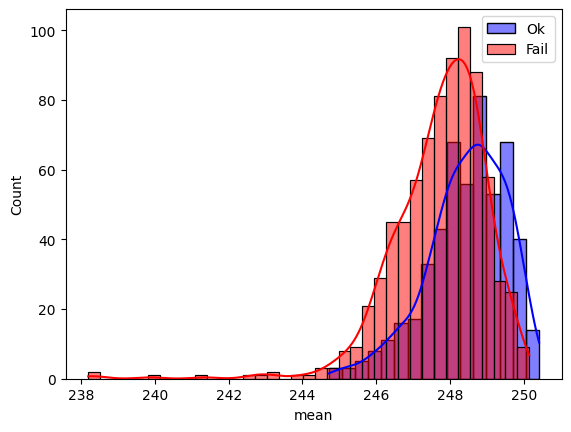

In [ ]:
sns.histplot(df_stats_ok['mean'], label='Ok', color='blue', alpha=0.5, kde=True)
sns.histplot(df_stats_def['mean'], label='Fail', color='red', alpha=0.5, kde=True)
# Add legend
plt.legend()

In [ ]:
#df_f=df_f[:300]
df_f.shape

(781, 262144)

In [ ]:
#df_p=df_p[:300]
df_p.shape

(519, 262144)

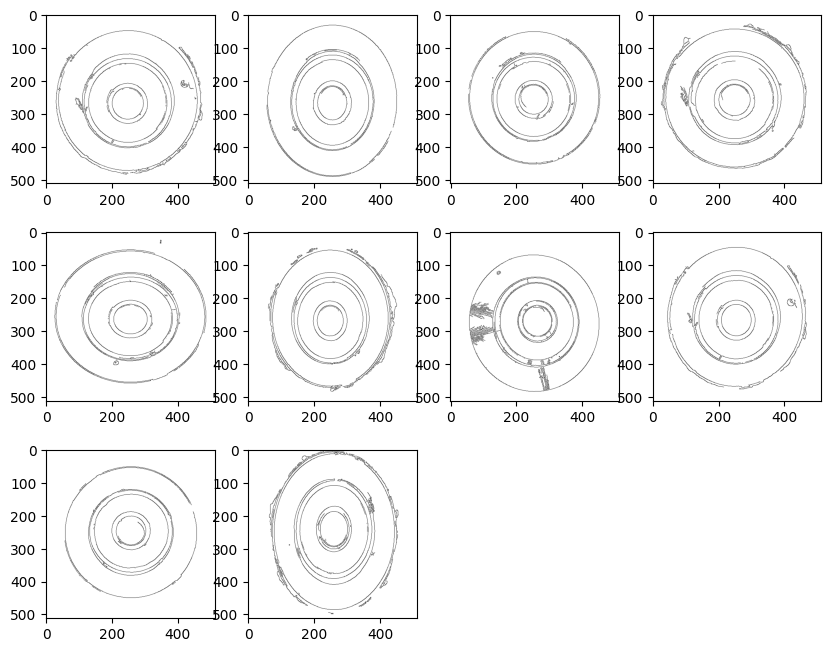

In [ ]:
#Fail or NoOkey or defective parts
plt.figure(figsize=(10,8))
for i in range(10):
    plt.subplot(3,4,i+1)
    plt.imshow(df_f.iloc[i:i+1,:].values.reshape(512,512,1),cmap='gray')

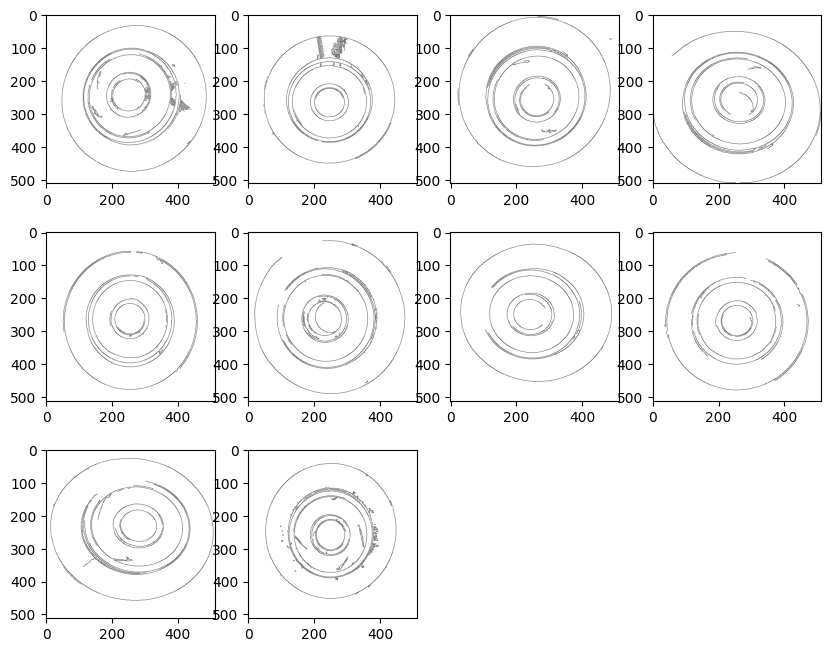

In [ ]:
#Pass or Okey or without defect parts
plt.figure(figsize=(10,8))
for i in range(10):
    plt.subplot(3,4,i+1)
    plt.imshow(df_p.iloc[i:i+1,:].values.reshape(512,512,1), cmap='gray')

In [ ]:
# Define Y or resonse
# 0 means Fail, and 1 mean Pass

df_f['Y']=0
df_p['Y']=1

In [ ]:
#Combine two dataframe
df=pd.concat([df_f,df_p], axis=0)
df.index=range(df.shape[0])
df.shape

(1300, 262145)

In [ ]:
#importing the Liberiers to create model
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from keras.layers import Dense,Convolution2D,MaxPool2D,Flatten
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report,confusion_matrix

In [ ]:
X=df.drop(labels='Y', axis=1)

X=X.values.reshape(X.shape[0],512,512,1)
#X=np.expand_dims(X, axis=-1)

Y=df[['Y']].values

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
Xtrain, Xtest, ytrain, ytest=train_test_split(X,Y,test_size=0.30,random_state=101 )

Model 2

In [ ]:
model=tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(
    filters=16,kernel_size=(3,3), activation='relu', input_shape=(512,512,1)))
model.add(tf.keras.layers.MaxPool2D(
    (2,2)))

model.add(tf.keras.layers.Conv2D(
    filters=32,kernel_size=(3,3), activation='relu'))
model.add(tf.keras.layers.MaxPool2D(
    (2,2)))

model.add(tf.keras.layers.Conv2D(
    filters=64,kernel_size=(3,3), activation='relu'))
model.add(tf.keras.layers.MaxPool2D(
    (2,2)))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))

model.add(tf.keras.layers.Dense(32, activation='relu'))

model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping=EarlyStopping(monitor='val_accuracy', patience=5, mode='min')

In [ ]:
model.fit(Xtrain,ytrain, epochs=20, batch_size=64, validation_data=(Xtest,ytest), callbacks=[early_stopping])

Epoch 1/20
15/15 [==============================] - 19s 311ms/step - loss: 268.4308 - accuracy: 0.5132 - val_loss: 0.5893 - val_accuracy: 0.7026
Epoch 2/20
15/15 [==============================] - 3s 198ms/step - loss: 0.5870 - accuracy: 0.7022 - val_loss: 0.5143 - val_accuracy: 0.7513
Epoch 3/20
15/15 [==============================] - 3s 198ms/step - loss: 0.4613 - accuracy: 0.7846 - val_loss: 0.5635 - val_accuracy: 0.6718
Epoch 4/20
15/15 [==============================] - 3s 199ms/step - loss: 0.6851 - accuracy: 0.7088 - val_loss: 0.6906 - val_accuracy: 0.5308
Epoch 5/20
15/15 [==============================] - 3s 199ms/step - loss: 0.6563 - accuracy: 0.7011 - val_loss: 0.7138 - val_accuracy: 0.6103
Epoch 6/20
15/15 [==============================] - 3s 195ms/step - loss: 0.4420 - accuracy: 0.7868 - val_loss: 0.5179 - val_accuracy: 0.7462
Epoch 7/20
15/15 [==============================] - 3s 196ms/step - loss: 0.2959 - accuracy: 0.8802 - val_loss: 0.4754 - val_accuracy: 0.7744
Epo

In [ ]:
ytest_pred=model.predict(Xtest)

13/13 [==============================] - 1s 27ms/step


In [ ]:
for i in range(len(ytest_pred)):
    if ytest_pred[i]>0.5:
        ytest_pred[i]=1
    else:
        ytest_pred[i]=0

In [ ]:
print(confusion_matrix(ytest,ytest_pred))
print(classification_report(ytest,ytest_pred))

[[213  37]
 [ 38 102]]
              precision    recall  f1-score   support

           0       0.85      0.85      0.85       250
           1       0.73      0.73      0.73       140

    accuracy                           0.81       390
   macro avg       0.79      0.79      0.79       390
weighted avg       0.81      0.81      0.81       390

